# AI Analysis of Movie Reviews: Sentiment 
This notebook performs sentiment analysis on IMDB movie reviews to determine 
if a review is positive or negative. It demonstrates a complete ML pipeline:
- Data loading and preprocessing
- Feature extraction using TF-IDF
- Model training and evaluation
- Comparison of different algorithms
- Error analysis and interpretation

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ssl
import pathlib
import time

# Text processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [15]:
# Set up NLTK data directory
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Use the user's home directory
home_dir = str(pathlib.Path.home())
nltk_data_dir = os.path.join(home_dir, 'nltk_data')

print(f"Path for saving NLTK data: {nltk_data_dir}")

# Create directory if it doesn't exist
os.makedirs(nltk_data_dir, exist_ok=True)

# Download NLTK resources
nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('wordnet', download_dir=nltk_data_dir)
nltk.download('punkt', download_dir=nltk_data_dir)

# Tell NLTK to look for data in our directory
nltk.data.path.append(nltk_data_dir)

Path for saving NLTK data: /Users/abobina/nltk_data


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abobina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/abobina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/abobina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Text Preprocessing Functions

In [16]:
def preprocess_text(text):
    """
    Preprocess text by performing the following steps:
    1. Convert to lowercase
    2. Remove HTML tags
    3. Remove URLs
    4. Remove special characters and numbers
    5. Tokenize
    6. Remove stopwords
    7. Lemmatize words
    
    Args:
        text (str): Input text to preprocess
        
    Returns:
        str: Cleaned and preprocessed text
    """
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Simple tokenization by spaces instead of nltk.word_tokenize
    tokens = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join back into text
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

#Test the function with an example
test_text = "This is a sample review! It contains some HTML <b>tags</b> and URLs like https://example.com."
print("Original text:")
print(test_text)
print("\nCleaned text:")
print(preprocess_text(test_text))

Original text:
This is a sample review! It contains some HTML <b>tags</b> and URLs like https://example.com.

Cleaned text:
sample review contains html tag url like


## Data Loading and Exploration

In [17]:
# Load the IMDB dataset
# Update the path to your dataset location
df = pd.read_csv('/Users/abobina/Downloads/IMDB Dataset.csv')

# Look at the first few rows
print("First few rows of the dataset:")
print(df.head())

# Basic information about the dataset
print(f"\nDataset size: {df.shape}")
print("\nClass distribution:")
print(df['sentiment'].value_counts())

First few rows of the dataset:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Dataset size: (50000, 2)

Class distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


## Data Preprocessing

In [18]:
# Apply preprocessing to all reviews
print("Preprocessing texts...")
df['cleaned_review'] = df['review'].apply(preprocess_text)

# Show an example of the processing result
sample_idx = 0  # index of the example
print(f"\nOriginal review:\n{df['review'].iloc[sample_idx][:300]}...")
print(f"\nCleaned review:\n{df['cleaned_review'].iloc[sample_idx][:300]}...")

Preprocessing texts...

Original review:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Tru...

Cleaned review:
one reviewer mentioned watching oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use wordit called oz nickname given oswald maximu...


## Data Splitting and Feature Extraction

In [19]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_review'], 
    df['sentiment'],
    test_size=0.2,      # Use 20% of data for testing
    random_state=42     # For reproducibility
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Vectorize texts using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Dimensionality of vectorized training set: {X_train_tfidf.shape}")

Training set size: 40000 samples
Test set size: 10000 samples
Dimensionality of vectorized training set: (40000, 5000)


## Base Model Training and Evaluation

Model accuracy: 0.8851

Classification report:
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      4961
    positive       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.88      0.89     10000
weighted avg       0.89      0.89      0.89     10000



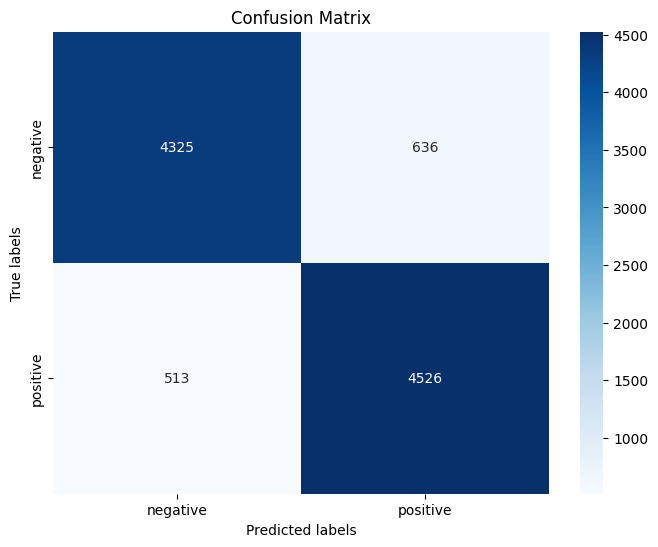

In [20]:
# Create and train a logistic regression model
log_reg = LogisticRegression(max_iter=1000, C=1.0)
log_reg.fit(X_train_tfidf, y_train)

# Make predictions on test data
y_pred = log_reg.predict(X_test_tfidf)

# Evaluate model quality
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Model accuracy: {accuracy:.4f}")
print("\nClassification report:")
print(report)

# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=log_reg.classes_, yticklabels=log_reg.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


## Feature Importance Analysis


Top 20 words characteristic of positive reviews:
great: 6.9006
excellent: 6.5735
perfect: 5.1475
best: 4.8957
wonderful: 4.7924
amazing: 4.6970
favorite: 4.5278
brilliant: 4.4128
loved: 4.3095
hilarious: 4.1055
enjoyed: 4.0507
today: 3.9234
fantastic: 3.8634
highly: 3.8456
superb: 3.8002
enjoyable: 3.7668
definitely: 3.6756
entertaining: 3.6754
perfectly: 3.6095
refreshing: 3.5108

Top 20 words characteristic of negative reviews:
worst: -10.1862
waste: -7.8997
bad: -7.3448
awful: -7.3311
boring: -6.5401
poor: -5.8754
terrible: -5.7729
nothing: -5.5151
dull: -5.0745
poorly: -5.0353
worse: -4.8681
disappointing: -4.8297
horrible: -4.8228
fails: -4.7474
disappointment: -4.5035
supposed: -4.3414
lame: -4.2589
unfortunately: -4.1964
annoying: -4.1873
wasted: -3.9839


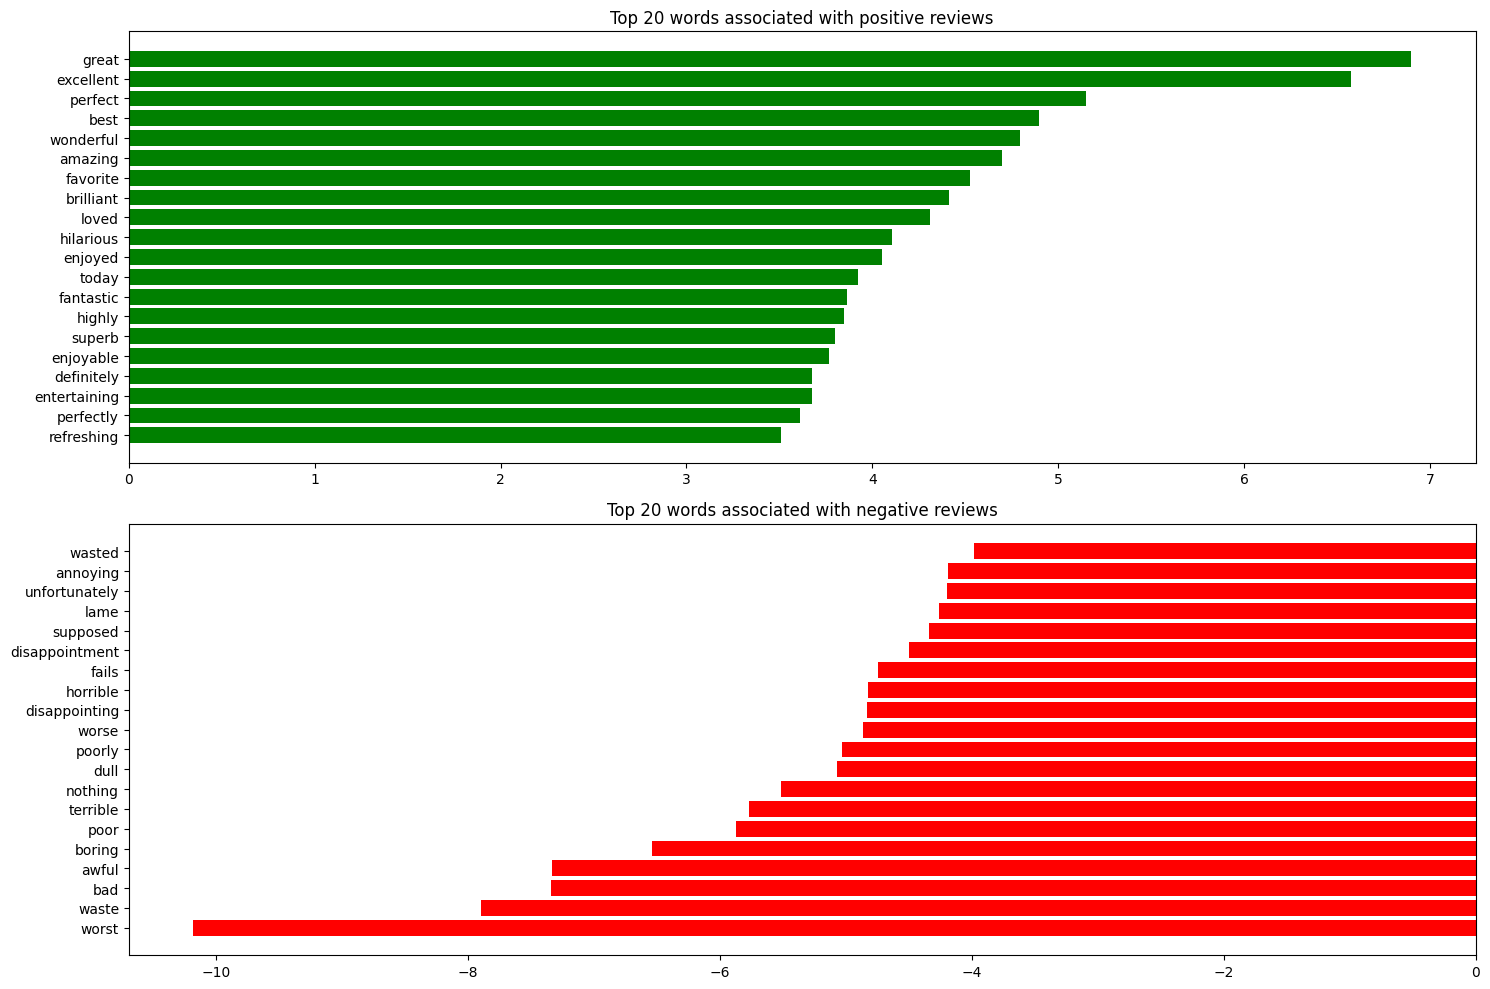

In [21]:
# Analyze the most important words for classification
feature_names = tfidf_vectorizer.get_feature_names_out()

# For binary classification we'll have one set of coefficients
coef = log_reg.coef_[0]

# Words with the largest positive and negative coefficients
# (they have the most influence on classification)
top_positive_coef = np.argsort(coef)[-20:]  # 20 most "positive" words
top_negative_coef = np.argsort(coef)[:20]   # 20 most "negative" words

print("\nTop 20 words characteristic of positive reviews:")
for idx in reversed(top_positive_coef):
    print(f"{feature_names[idx]}: {coef[idx]:.4f}")

print("\nTop 20 words characteristic of negative reviews:")
for idx in top_negative_coef:
    print(f"{feature_names[idx]}: {coef[idx]:.4f}")

# Visualization
plt.figure(figsize=(15, 10))

# Plot for positive words
plt.subplot(2, 1, 1)
colors = ['green'] * len(top_positive_coef)
plt.barh(range(len(top_positive_coef)), coef[top_positive_coef], color=colors)
plt.yticks(range(len(top_positive_coef)), [feature_names[i] for i in top_positive_coef])
plt.title('Top 20 words associated with positive reviews')

# Plot for negative words
plt.subplot(2, 1, 2)
colors = ['red'] * len(top_negative_coef)
plt.barh(range(len(top_negative_coef)), coef[top_negative_coef], color=colors)
plt.yticks(range(len(top_negative_coef)), [feature_names[i] for i in top_negative_coef])
plt.title('Top 20 words associated with negative reviews')

plt.tight_layout()
plt.show()

## Creating a Prediction Function

In [22]:
# Function to predict sentiment of new text
def predict_sentiment(text):
    """
    Predict the sentiment of a given text
    
    Args:
        text (str): Input text for sentiment analysis
        
    Returns:
        dict: Dictionary containing the original text, cleaned text,
              prediction, and confidence level
    """
    # Preprocess text
    cleaned_text = preprocess_text(text)
    # Vectorize
    vectorized_text = tfidf_vectorizer.transform([cleaned_text])
    # Predict
    prediction = log_reg.predict(vectorized_text)[0]
    # Class probabilities
    probabilities = log_reg.predict_proba(vectorized_text)[0]
    
    result = {
        'text': text,
        'cleaned_text': cleaned_text,
        'prediction': prediction,
        'confidence': max(probabilities)
    }
    
    return result

# Examples for testing
test_examples = [
    "This movie was absolutely fantastic! I loved every moment of it.",
    "I hated this product, it was a complete waste of money.",
    "The service was okay, not great but not terrible either.",
    "I'm not sure if I liked it or not, it had good and bad moments."
]

# Test our function on examples
print("Testing sentiment prediction function on examples:")
for example in test_examples:
    result = predict_sentiment(example)
    print(f"Text: {result['text']}")
    print(f"Cleaned text: {result['cleaned_text']}")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print("-" * 50)

Testing sentiment prediction function on examples:
Text: This movie was absolutely fantastic! I loved every moment of it.
Cleaned text: movie absolutely fantastic loved every moment
Prediction: positive
Confidence: 0.9745
--------------------------------------------------
Text: I hated this product, it was a complete waste of money.
Cleaned text: hated product complete waste money
Prediction: negative
Confidence: 0.9966
--------------------------------------------------
Text: The service was okay, not great but not terrible either.
Cleaned text: service okay great terrible either
Prediction: negative
Confidence: 0.9190
--------------------------------------------------
Text: I'm not sure if I liked it or not, it had good and bad moments.
Cleaned text: im sure liked good bad moment
Prediction: negative
Confidence: 0.5904
--------------------------------------------------


## Hyperparameter Optimization

In [23]:
# Define parameter grid for search
param_grid = {
    'C': [0.1, 1.0, 10.0],      # Regularization parameter
    'penalty': ['l1', 'l2'],     # Regularization type
    'solver': ['liblinear', 'saga']  # Optimization algorithm
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    verbose=1,
    n_jobs=-1  # Use all available processor cores
)

# Train model on different parameters
print("Performing search for optimal parameters...")
grid_search.fit(X_train_tfidf, y_train)

# Best parameters and results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy with cross-validation: {grid_search.best_score_:.4f}")

# Test best model on test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_tfidf)
best_accuracy = accuracy_score(y_test, y_pred_best)
best_report = classification_report(y_test, y_pred_best)

print(f"\nAccuracy of best model on test set: {best_accuracy:.4f}")
print("\nClassification report for best model:")
print(best_report)

Performing search for optimal parameters...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy with cross-validation: 0.8829

Accuracy of best model on test set: 0.8849

Classification report for best model:
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      4961
    positive       0.88      0.90      0.89      5039

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



## Model Comparison

Training model: Logistic Regression
  Accuracy: 0.8851
  Training time: 0.19 seconds
--------------------------------------------------
Training model: Random Forest
  Accuracy: 0.8479
  Training time: 29.83 seconds
--------------------------------------------------
Training model: Naive Bayes
  Accuracy: 0.8497
  Training time: 0.05 seconds
--------------------------------------------------
Training model: Linear SVM
  Accuracy: 0.8785
  Training time: 0.39 seconds
--------------------------------------------------


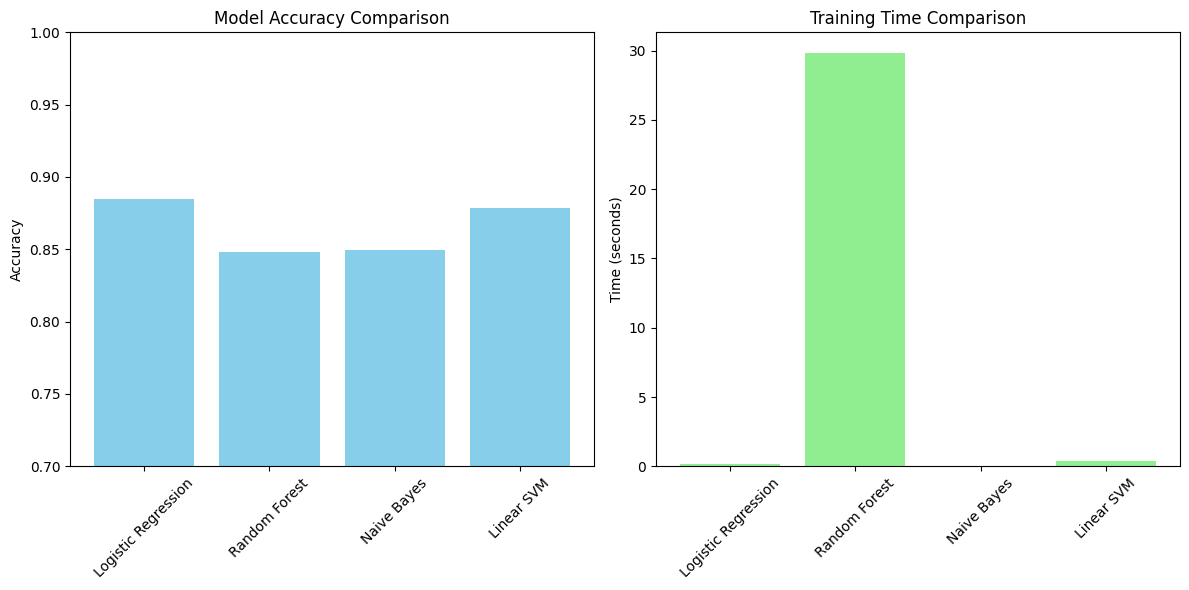

Best model by accuracy: Logistic Regression with accuracy 0.8851


In [24]:
# List of models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(max_iter=1000)
}

# Compare models
results = {}

for name, model in models.items():
    print(f"Training model: {name}")
    start_time = time.time()
    
    # Train model
    model.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_tfidf)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    training_time = time.time() - start_time
    
    # Save results
    results[name] = {
        'accuracy': acc,
        'training_time': training_time,
        'model': model
    }
    
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Training time: {training_time:.2f} seconds")
    print("-" * 50)

# Visualize results
plt.figure(figsize=(12, 6))

# Model accuracy
plt.subplot(1, 2, 1)
accuracies = [results[name]['accuracy'] for name in models.keys()]
plt.bar(models.keys(), accuracies, color='skyblue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)  # Usually accuracy is above 0.7
plt.xticks(rotation=45)

# Training time
plt.subplot(1, 2, 2)
times = [results[name]['training_time'] for name in models.keys()]
plt.bar(models.keys(), times, color='lightgreen')
plt.title('Training Time Comparison')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Choose best model by accuracy
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
print(f"Best model by accuracy: {best_model_name} with accuracy {results[best_model_name]['accuracy']:.4f}")

## Error Analysis

In [25]:
# Use the best model for error analysis
best_model = results[best_model_name]['model']
y_pred = best_model.predict(X_test_tfidf)

# Get indices of misclassified examples
misclassified_indices = np.where(y_pred != y_test)[0]

# Show several error examples
print(f"Number of misclassified examples: {len(misclassified_indices)}")
print("\nExamples of classification errors:")

# Convert Series back to regular list for indexing
y_test_list = y_test.reset_index(drop=True)
X_test_list = X_test.reset_index(drop=True)

for i in misclassified_indices[:5]:  # Show first 5 errors
    true_sentiment = y_test_list[i]
    predicted_sentiment = y_pred[i]
    original_text = X_test_list[i]
    
    print(f"Example #{i}")
    print(f"Original text: {original_text[:100]}...")
    print(f"True label: {true_sentiment}")
    print(f"Predicted label: {predicted_sentiment}")
    print("-" * 50)

Number of misclassified examples: 1149

Examples of classification errors:
Example #0
Original text: really liked summerslam due look arena curtain look overall interesting reason anyways could one bes...
True label: positive
Predicted label: negative
--------------------------------------------------
Example #7
Original text: okay didnt get purgatory thing first time watched episode seemed like something significant going co...
True label: positive
Predicted label: negative
--------------------------------------------------
Example #20
Original text: production quality cast premise authentic new england waterbury ct locale lush john williams score r...
True label: positive
Predicted label: negative
--------------------------------------------------
Example #23
Original text: movie released originally soft x apparently explicit sex deleted later producer relented smelled mon...
True label: positive
Predicted label: negative
--------------------------------------------------
Example #29